# Autoencoders (AE)

The **MNIST dataset** consists of 60,000 images of hand written digit, where each image has size 28X28.

We will define and train two **autoencoders (AEs)** on the MNIST dataset:
- A simple autoencoder composed of linear layers
- A more complex autoencoder composed of convolutional layers.

<img src="figures/mnist.png" width="600px"/>

## 0. Librairies

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [30]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

device(type='mps')

## 1. Load MNIST data

- The following code loads the MNIST data.
- Note that we don't need any validation set, since we are in an unsupervised setting.

In [31]:
# data
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True,
                            transform=transform)

In [34]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [35]:
len(train_loader) * 64

60032

In [36]:
# data format
data_iter = iter(train_loader)
images, labels = next(data_iter)
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [37]:
torch.min(images), torch.max(images)

(tensor(0.), tensor(1.))

## 2. AE with linear layers

### Model

The following class implements an **autoencoder (AE)** composed of **linear layers**.

- Understand the architecture of this **autonecoder (AE)**.

In [38]:
class Autoencoder_Linear(nn.Module):
    """Implements an linear automencoder"""

    def __init__(self):
        """constructor"""

        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 2) # -> N, 2 only!
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()             # output neurons between 0 and 1
        )

    def forward(self, x):
        """forward pass"""
        
        encoded_data = self.encoder(x)
        decoded_data = self.decoder(encoded_data)

        return decoded_data

### Training

- Define a **loss (`MSEloss`)** and an **optimizer (`torch.optim.Adam`)** with learning rate `lr=1e-3` for this model.

- Implement a **training loop** for this model during $24$ epochs. During training, after each epoch, store the current `epoch`, `inputs`, `outputs` and `train_loss` of the model (in this order) in a list called `outputs_l`.

In [41]:
model_1 = Autoencoder_Linear().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), 
                             lr=1e-3, 
                             weight_decay=1e-5)

In [42]:
num_epochs = 24
outputs_l = []

for epoch in range(num_epochs):
    train_loss = 0.0

    for (inputs, _) in train_loader:
        inputs = inputs.reshape(-1, 28*28).to(device)  # move to device

        optimizer.zero_grad()
        outputs = model_1(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)  # sum batch loss

    train_loss /= len(train_loader.dataset)  # average over all samples
    print(f'Epoch:{epoch+1} \t Train loss: {train_loss:.4f}')

    # Only store the last batch (optional: move to CPU)
    outputs_l.append((epoch, inputs.cpu(), outputs.cpu(), train_loss))


Epoch:1 	 Train loss: 0.0614
Epoch:2 	 Train loss: 0.0503
Epoch:3 	 Train loss: 0.0478
Epoch:4 	 Train loss: 0.0465
Epoch:5 	 Train loss: 0.0454
Epoch:6 	 Train loss: 0.0443
Epoch:7 	 Train loss: 0.0435
Epoch:8 	 Train loss: 0.0428
Epoch:9 	 Train loss: 0.0422
Epoch:10 	 Train loss: 0.0417
Epoch:11 	 Train loss: 0.0413
Epoch:12 	 Train loss: 0.0410
Epoch:13 	 Train loss: 0.0407
Epoch:14 	 Train loss: 0.0406
Epoch:15 	 Train loss: 0.0406
Epoch:16 	 Train loss: 0.0402
Epoch:17 	 Train loss: 0.0401
Epoch:18 	 Train loss: 0.0399
Epoch:19 	 Train loss: 0.0397
Epoch:20 	 Train loss: 0.0396
Epoch:21 	 Train loss: 0.0394
Epoch:22 	 Train loss: 0.0399
Epoch:23 	 Train loss: 0.0395
Epoch:24 	 Train loss: 0.0393


### Results

- Plot the training loss to confirm that the model has been trained.

- Run the following code which displays the inputs and their reconstructions by the autoencoder at epochs $1$, $12$ and $24$. The reconstructions should improve as the epochs increase.

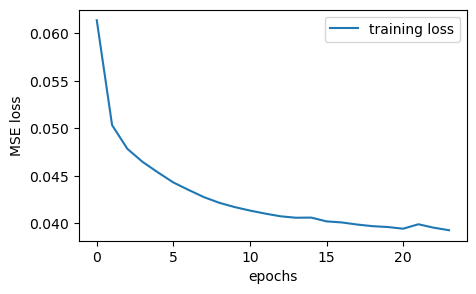

In [43]:
plt.figure(figsize=(5, 3))

epochs = [x[0] for x in outputs_l]
train_loss = [x[3] for x in outputs_l]

plt.plot(epochs, train_loss, label="training loss")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.savefig('figures/AE_linear_loss.pdf', format='pdf', bbox_inches='tight')
#plt.show()

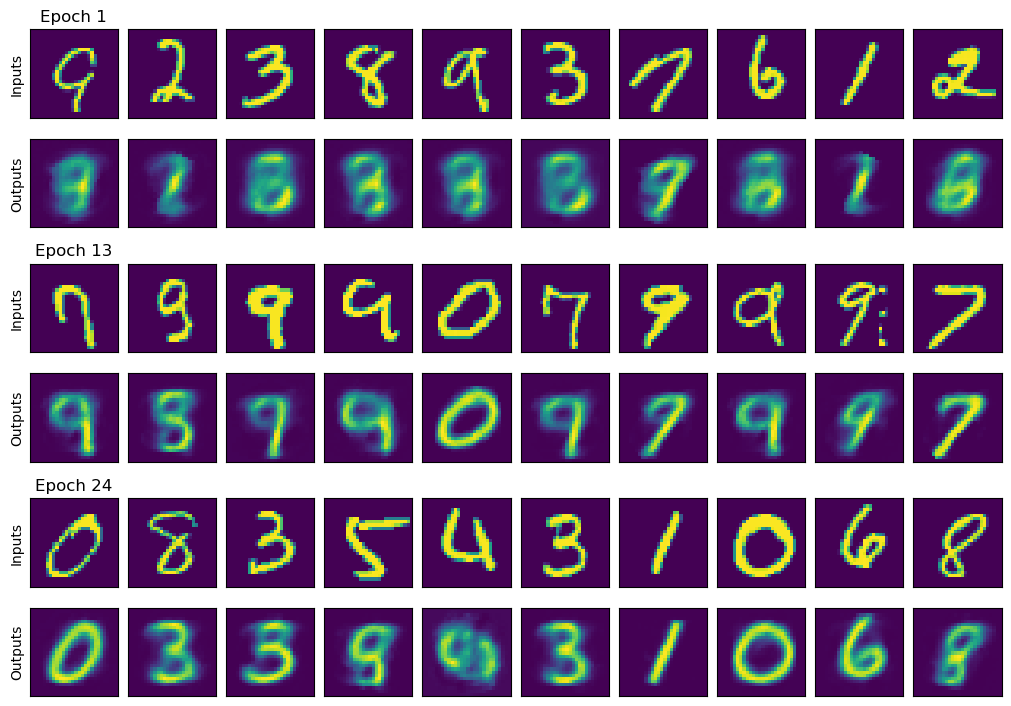

In [44]:
fig, axs = plt.subplots(6, 10, 
                        figsize=(10, 7), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i, k in enumerate([0, num_epochs//2, num_epochs-1]):

    inputs = outputs_l[k][1].detach().numpy()
    outputs = outputs_l[k][2].detach().numpy()

    axs[2*i, 0].set_title(f"Epoch {k+1}")
    axs[2*i, 0].set_ylabel("Inputs")

    for j, item in enumerate(inputs):

        if j >= 10: break
        item = item.reshape(-1, 28,28) # for Autoencoder_Linear
        axs[2*i, j].imshow(item[0])
        axs[2*i, j].set_xticks([])
        axs[2*i, j].set_yticks([])

    axs[2*i + 1, 0].set_ylabel("Outputs")
    for j, item in enumerate(outputs):

        if j >= 10: break
        item = item.reshape(-1, 28,28) # for Autoencoder_Linear
        axs[2*i + 1, j].imshow(item[0])
        axs[2*i + 1, j].set_xticks([])
        axs[2*i + 1, j].set_yticks([])

fig.savefig('figures/AE_linear.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 3. AE with convolutional layers

### Model

The following class implements an **autoencoder (AE)** composed of **convolutional layers**.

- Understand the architecture of this **autonecoder (AE)**.

In [45]:
class Autoencoder_CNN(nn.Module):
    """Implements a CNN autoencoder"""

    def __init__(self):
        """constructor"""

        super().__init__()

        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            # -> N, 16, 14, 14
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            # -> N, 32, 7, 7
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            # -> N, 64, 1, 1
            nn.Conv2d(32, 64, 7)
            )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            # -> N, 32, 7, 7
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            # N, 16, 14, 14 (N, 16, 13, 13 without output_padding)
            nn.ConvTranspose2d(32, 16, 3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # N, 1, 28, 28 (N,1, 27, 27)
            nn.ConvTranspose2d(16, 1, 3, 
                               stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            )

    def forward(self, x):
        """forward function"""

        encoded_data = self.encoder(x)
        decoded_data = self.decoder(encoded_data)

        return decoded_data


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

### Training

- Define a **loss** (`MSEloss`) and an **optimizer** (`torch.optim.Adam`) with learning rate `lr=1e-3` for this model.

- Implement a **training loop** for this model during $12$ epochs. During training, after each epoch, store the current `epoch`, `inputs`, `outputs` and `train_loss` of the model (in this order) in a list called `outputs_l`.

In [46]:
model_2 = Autoencoder_CNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), 
                             lr=1e-3, 
                             weight_decay=1e-5)

In [47]:
num_epochs = 12
outputs_l = []

for epoch in range(num_epochs):
    train_loss_sum = 0.0

    for inputs, _ in train_loader:
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model_2(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * inputs.size(0)

    train_loss = train_loss_sum / len(train_loader.dataset)
    print(f'Epoch:{epoch+1} \t Train loss: {train_loss:.4f}')

    # Store last batch outputs on CPU to avoid memory issues
    with torch.no_grad():
        outputs_l.append((epoch, inputs.cpu(), outputs.cpu(), train_loss))


Epoch:1 	 Train loss: 0.0318
Epoch:2 	 Train loss: 0.0067
Epoch:3 	 Train loss: 0.0047
Epoch:4 	 Train loss: 0.0038
Epoch:5 	 Train loss: 0.0034
Epoch:6 	 Train loss: 0.0031
Epoch:7 	 Train loss: 0.0030
Epoch:8 	 Train loss: 0.0029
Epoch:9 	 Train loss: 0.0028
Epoch:10 	 Train loss: 0.0028
Epoch:11 	 Train loss: 0.0027
Epoch:12 	 Train loss: 0.0027


### Results

- Plot the training loss to confirm that the model has been trained.

- Run the following code which displays the inputs and their reconstructions by the autoencoder at epochs $1$, $7$ and $12$. The reconstructions should improve as the epochs increase.

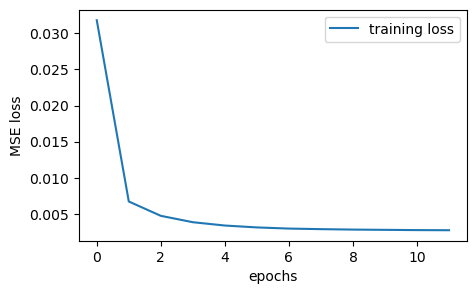

In [48]:
plt.figure(figsize=(5, 3))

epochs = [x[0] for x in outputs_l]
train_loss = [x[3] for x in outputs_l]

plt.plot(epochs, train_loss, label="training loss")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.savefig('figures/AE_cnn_loss.pdf', format='pdf', bbox_inches='tight')
#plt.show()

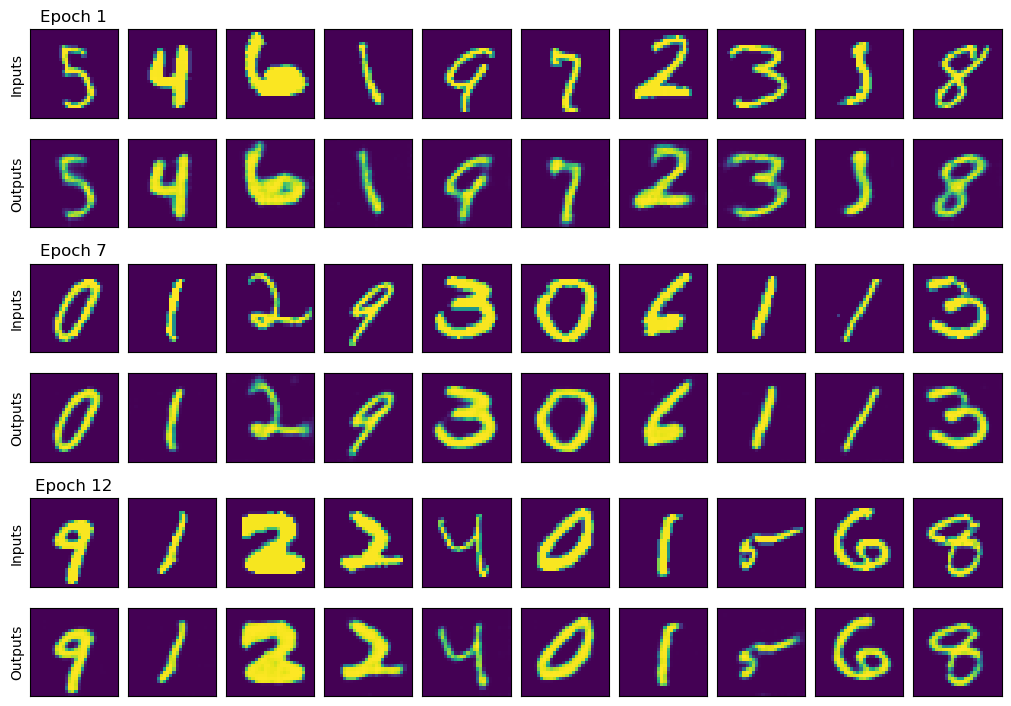

In [50]:
fig, axs = plt.subplots(6, 10, 
                        figsize=(10, 7), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i, k in enumerate([0, num_epochs//2, num_epochs-1]):

    inputs = outputs_l[k][1].detach().numpy()
    outputs = outputs_l[k][2].detach().numpy()

    axs[2*i, 0].set_title(f"Epoch {k+1}")
    axs[2*i, 0].set_ylabel("Inputs")

    for j, item in enumerate(inputs):

        if j >= 10: break
        axs[2*i, j].imshow(item[0])
        axs[2*i, j].set_xticks([])
        axs[2*i, j].set_yticks([])

    axs[2*i + 1, 0].set_ylabel("Outputs")
    for j, item in enumerate(outputs):

        if j >= 10: break
        axs[2*i + 1, j].imshow(item[0])
        axs[2*i + 1, j].set_xticks([])
        axs[2*i + 1, j].set_yticks([])

fig.savefig('figures/AE_cnn.pdf', format='pdf', bbox_inches='tight')
# plt.show()

## 4. Visualizing the latent space

- Select about 1000 input images, about 100 samples of each input digit (0, 1, 2, ..., 9) (around 1000 / 64 = 16 batches), from your dataset.

- Compute the **encodings** of these samples in the **2D latent space**. For this purpose, note that the **encoder** part of the **autoencoder** `model` can be selected using tthe following instruction: `encoder = model.encoder.eval()`

- Plot the encoded data in the 2D latent space with their original labels in different colors. This will give you an idea of how the different data are distributed in the latent sapce.

In [51]:
# torch.save(model_1.state_dict(), "data/AE_linear.pt")

In [52]:
model_1 = Autoencoder_Linear().to(device)
model_1.load_state_dict(torch.load("data/AE_linear.pt"))
model_1.eval()

Autoencoder_Linear(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [53]:
encoder = model_1.encoder.eval()
encoder

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=12, bias=True)
  (5): ReLU()
  (6): Linear(in_features=12, out_features=2, bias=True)
)

In [56]:
nb_batches = 16
data_d = {"images" : [], "labels" : []}

for i, batch in enumerate(train_loader):
    
    with torch.no_grad():

        images, labels = batch[0].to(device), batch[1].to(device)
        images = images.reshape(-1, 28*28)

        encoded_images = encoder(images)

        if i == nb_batches:
            break
        else:
            data_d["images"].extend(encoded_images)
            data_d["labels"].extend(labels)

In [57]:
nb_images = len(data_d["images"])
nb_labels = len(data_d["labels"])

print(f"Nb of encoded images: {nb_images}")
print(f"Nb of labels: {nb_labels}")

Nb of encoded images: 1024
Nb of labels: 1024


In [58]:
latent_images = torch.cat(data_d["images"], axis=0).reshape(-1, 2)
labels = torch.tensor(data_d["labels"])

latent_images.shape, labels.shape

(torch.Size([1024, 2]), torch.Size([1024]))

In [59]:
for i in range(10):
    print((labels==i).sum())

tensor(104)
tensor(116)
tensor(91)
tensor(113)
tensor(98)
tensor(94)
tensor(108)
tensor(114)
tensor(85)
tensor(101)


/var/folders/jj/mflbhpsx5fn9czwyvl39hk_r0000gn/T/ipykernel_6439/2340764432.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('rainbow', 10)


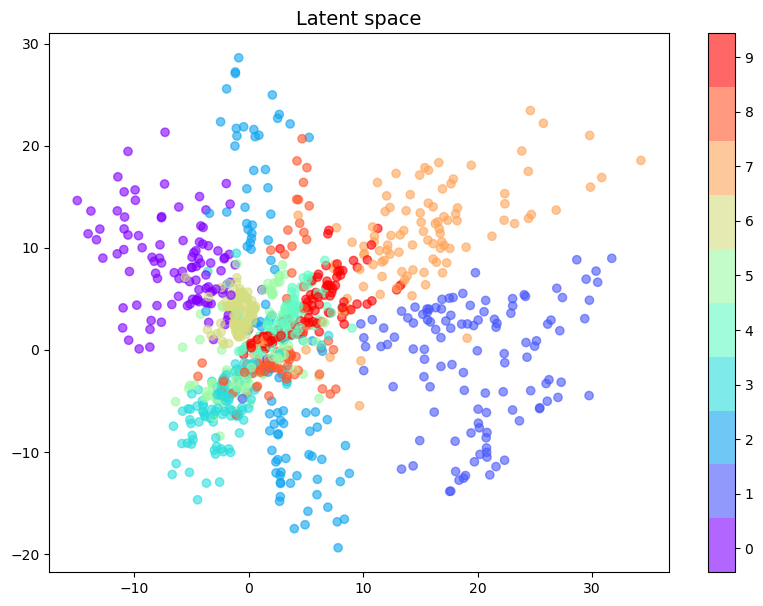

In [61]:
import numpy as np

x = latent_images[:, 0].to("cpu")
y = latent_images[:, 1].to("cpu")

plt.figure(figsize=(10, 7))
plt.title("Latent space", size=14)

cm = plt.cm.get_cmap('rainbow', 10)

plt.scatter(x, y, c=labels, alpha=0.6, cmap=cm)

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(0.4, 8.6, 10))
cbar.set_ticklabels(list(range(0, 10)))

plt.savefig('figures/AE_latent_space.pdf', format='pdf', bbox_inches='tight')
# plt.show()

## 5. Generative capabilities of the decoder

### 5.1: Uniform sampling from the latent space

- By considering the 1000 encoded data of the preovous exercice, estimate the minimal and maximal coordinates $x$ and $y$ of your encoded data in the 2D-latent space ($x_{min}$, $x_{max}$, $y_{min}$, $y_{max}$).

- Sample 100 2D-points from the latent space according to the uniform distribution $\mathcal{U}([x_{min}, x_{max}], [y_{min}, y_{max}])$.<br>
For this purpose, you can use the instruction:<br> 
`np.random.uniform(low=xy_min, high=xy_max, size=(100,2))`

- Compute the **decoded images** of these 2D-points. For this purpose, note that the **decoder** part of the **autoencoder** `model` can be selected using tthe following instruction: `decoder = model.decoder.eval()`. Store these images in a list called `decoded_samples`.

- At this stage, you have **generated** new images by *sampling* the 2D-latent space and *decoding* these samples. Plot these decoded images. Are these images of good quality? Do they resemble to the digits of the dataset?

In [62]:
import numpy as np

In [63]:
decoder = model_1.decoder.eval()
decoder

Sequential(
  (0): Linear(in_features=2, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=784, bias=True)
  (7): Sigmoid()
)

In [64]:
minx, maxx = min(x).item(), max(x).item()
miny, maxy = min(y).item(), max(y).item()

minx, maxx, miny, maxy

(-14.972748756408691, 34.26193618774414, -19.388916015625, 28.62724494934082)

In [72]:
# Sample from a uniform distribution on the latent space
xy_min = [minx, miny]
xy_max = [maxx, maxy]

samples_uniform = np.random.uniform(low=xy_min, high=xy_max, size=(100,2))
samples_uniform = torch.tensor(samples_uniform).float()

In [73]:
samples_uniform.shape

torch.Size([100, 2])

/var/folders/jj/mflbhpsx5fn9czwyvl39hk_r0000gn/T/ipykernel_6439/3334683801.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('rainbow', 10)


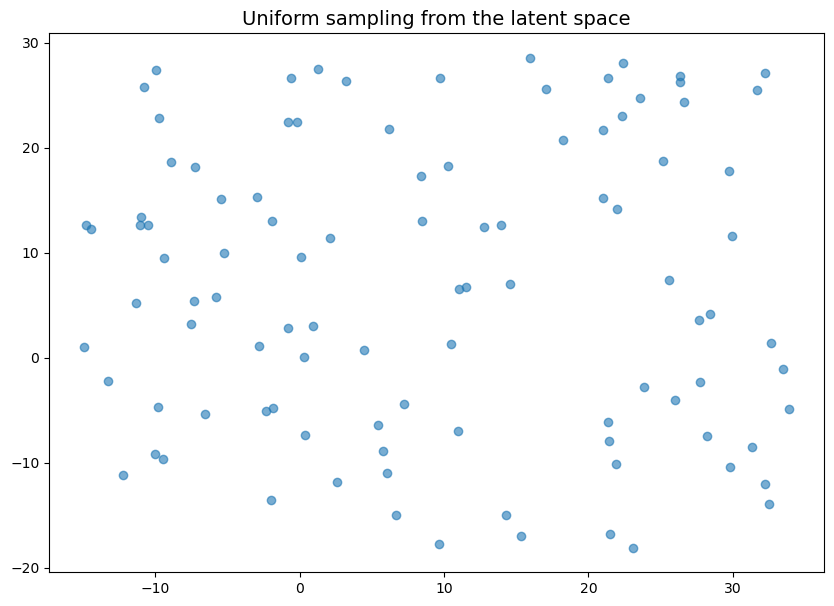

In [74]:
x = samples_uniform[:, 0]
y = samples_uniform[:, 1]

plt.figure(figsize=(10, 7))
plt.title("Uniform sampling from the latent space", size=14)

cm = plt.cm.get_cmap('rainbow', 10)

plt.scatter(x, y, alpha=0.6)

plt.savefig('figures/AE_uniform_sampling.pdf', format='pdf', bbox_inches='tight')
# plt.show()

In [75]:
with torch.no_grad():
    decoded_samples = decoder(samples_uniform.to(device))

decoded_samples = decoded_samples.reshape(100, 28, 28)
decoded_samples.shape

torch.Size([100, 28, 28])

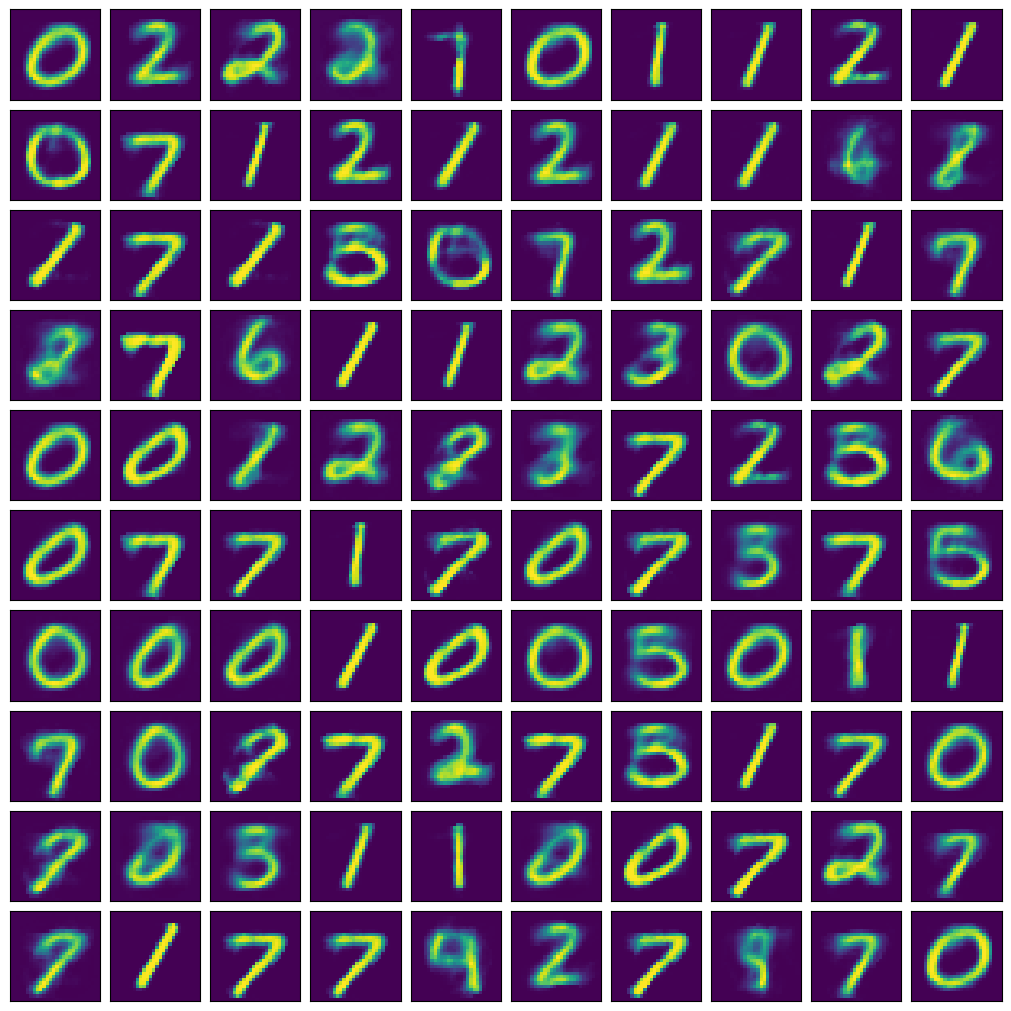

In [80]:
fig, axs = plt.subplots(10, 10, 
                        figsize=(10, 10), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i in range(10):
    
    samples = decoded_samples[10*i:10*i+10, :, :].cpu()
    for j in range(10):
    
        axs[i, j].imshow(samples[j, :, :])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])


fig.savefig('figures/AE_generator_uniform.pdf', format='pdf', bbox_inches='tight')
# plt.show()

### 5.2 Normal sampling from the latent space

- By considering the 1000 encoded data of the preovous exercice, estimate the mean $\mu$ and variance $\sigma^2$ of your encoded data in the 2D-latent space.

- Sample 100 2D-points from the latent space according to the normal distribution $\mathcal{UN}(\mu, \sigma^2)$.<br>
For this purpose, you can use the instruction:<br> 
`np.random.multivariate_normal(mean, cov, (100))`<br>
where `cov` is the diagonal matrix where the diagonal is the variance vector.

- Compute the **decoded images** of these 2D-points. For this purpose, note that the **decoder** part of the **autoencoder** `model` can be selected using tthe following instruction: `decoder = model.decoder.eval()`. Store these images in a list called `decoded_samples`.

- At this stage, you have **generated** new images by *sampling* the 2D-latent space and *decoding* these samples. Plot these decoded images. Are these images of good quality? Do they resemble to the digits of the dataset?

In [85]:
# Sample from a normal distribution on the latent space
mean = torch.mean(latent_images, axis=0).cpu()
std = torch.std(latent_images, axis=0).cpu()
cov = (torch.diag(std)**2).cpu()

samples_normal = np.random.multivariate_normal(mean, cov, (100))
samples_normal = torch.tensor(samples_normal).float()
samples_normal.shape

/var/folders/jj/mflbhpsx5fn9czwyvl39hk_r0000gn/T/ipykernel_6439/109298122.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples_normal = np.random.multivariate_normal(mean, cov, (100))


torch.Size([100, 2])

/var/folders/jj/mflbhpsx5fn9czwyvl39hk_r0000gn/T/ipykernel_6439/1666651802.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('rainbow', 10)


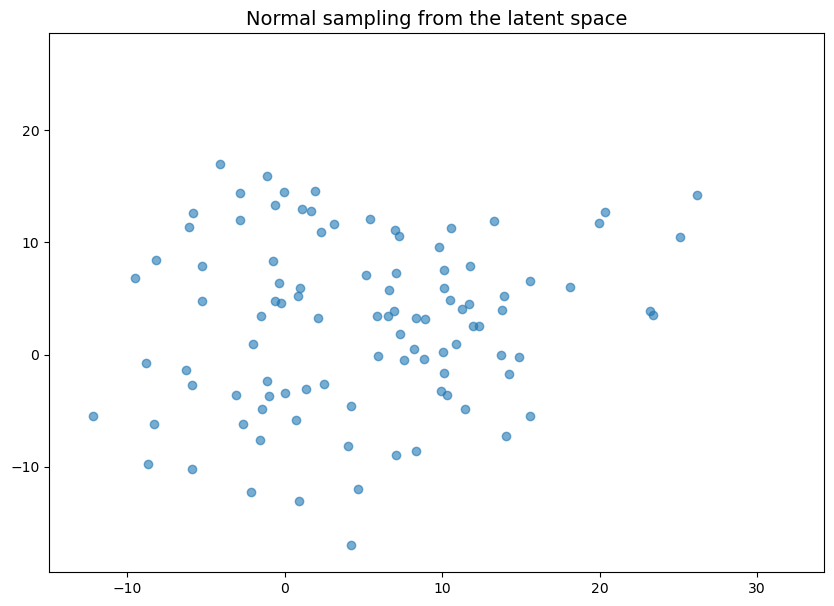

In [86]:
x = samples_normal[:, 0]
y = samples_normal[:, 1]

plt.figure(figsize=(10, 7))
plt.title("Normal sampling from the latent space", size=14)

cm = plt.cm.get_cmap('rainbow', 10)

plt.scatter(x, y, alpha=0.6)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

plt.savefig('figures/AE_normal_sampling.pdf', format='pdf', bbox_inches='tight')
# plt.show()

In [88]:
with torch.no_grad():
    decoded_samples = decoder(samples_normal.to(device))

decoded_samples = decoded_samples.reshape(100, 28, 28)
decoded_samples.shape

torch.Size([100, 28, 28])

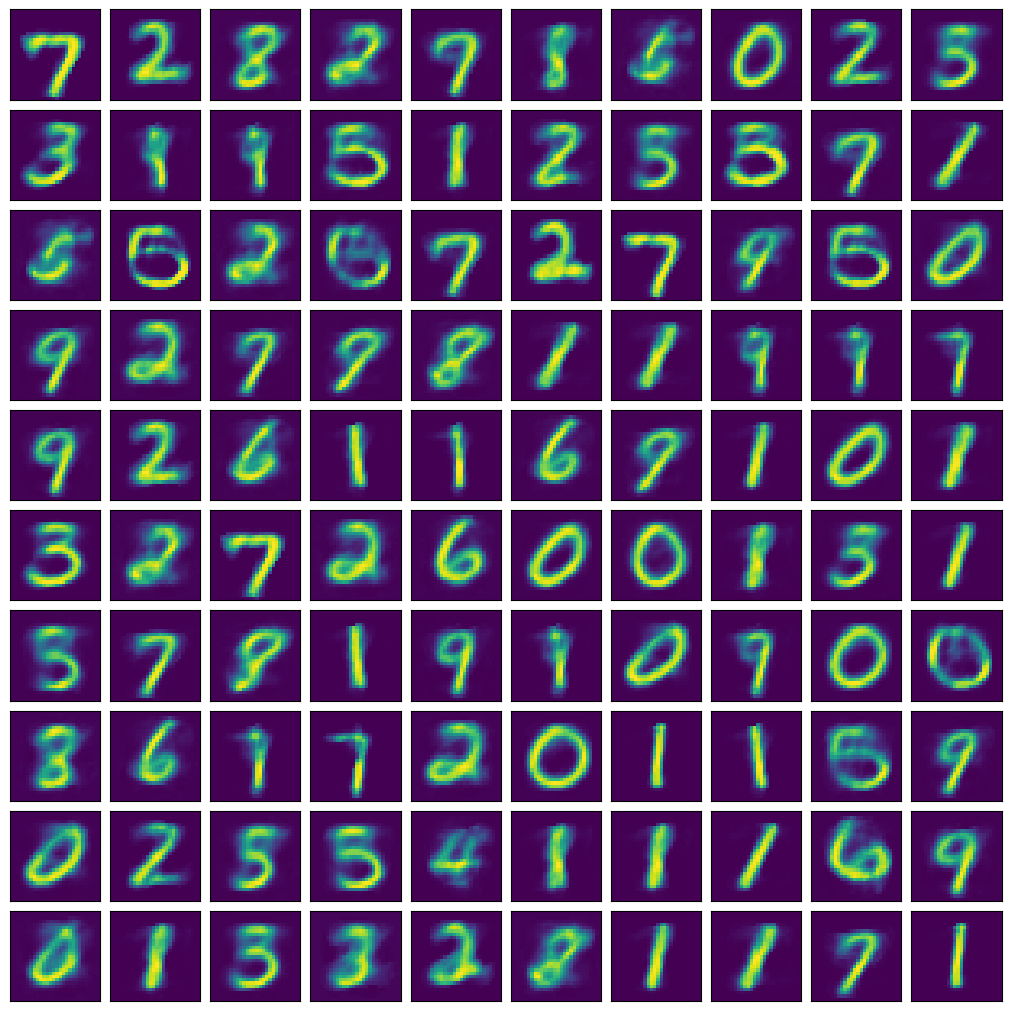

In [90]:
fig, axs = plt.subplots(10, 10, 
                        figsize=(10, 10), 
                        layout="constrained",
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i in range(10):
    
    samples = decoded_samples[10*i:10*i+10, :, :].cpu()
    
    for j in range(10):
    
        axs[i, j].imshow(samples[j, :, :])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])


fig.savefig('figures/AE_generator_normal.pdf', format='pdf', bbox_inches='tight')
# plt.show()

**Conclusion:** In both cases, the generated data are somewhat blurry and some numbers are over-represented.